In [2]:
import pandas as pd
import datetime as dt
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import eb

In [8]:
import time

# status generator
def range_with_status(total):
    """ iterate from 0 to total and show progress in console """

    while n < total:
        
        done = '#'*(n+1)
        todo = '-'*(total-n-1)
        
        s = f'<{done+todo}>'
        
        if not todo:
            s+='\n'        
        
        if n>0:
            s = '\r'+s
        print(s, end='')
        
        yield n

        n+=1

# example for use of status generator
for i in range_with_status(457):
    time.sleep(0.01)

<#########################################################################################################################################################################################################################################################################################################################################################################################################################################################################>


In [3]:

lehrstuhl=False
##############################################################___Input Daten___##############################################################
#############################################################################################################################################

#paths
em_path = eb.em_path    #new datasheets
files = [os.path.join(em_path,name) for name in os.listdir(em_path)]
n_files = len(files)

db_loc = eb.dir_db      #database location
if lehrstuhl:
    db_loc = os.path.join(eb.dir_db_ls,'EM')

#open name-file to assign meter ID to building/app/meter
name_file = 'energymeter.config'
name_file = os.path.join(os.getcwd(),name_file)
#for .py:
#name_file = os.path.join(os.path.dirname(os.path.realpath(__file__)),name_file)
if not os.path.isfile(name_file):
    print('config file nicht gefunden...!')
    quit()
meters = pd.read_csv(name_file,sep=';')

#startdate of regular observations
start = dt.datetime(2021,9,2)


In [4]:
n_files

464

In [5]:
################################################################___Skript___#################################################################
#############################################################################################################################################
data = []
# reading datasheets
print(f'-reading files from Database...')
for nf, fn in enumerate(files):
    eb.running_bar(nf,n_files)
    #print(f'({nf}/{n_files}) files read... ', end='\r', flush=True)
    datasheet =         pd.read_csv(fn,  
        engine='python',
        sep=';',
        na_values=['-','#N/V','#NV'],
        decimal= ','
    )
    datasheet.insert(0,'Datetime',pd.to_datetime(datasheet['Timestamp'],yearfirst=True,dayfirst=False,infer_datetime_format=True))
    datasheet = datasheet.drop(axis=1,labels = 'Timestamp')
    data.append(datasheet)
df = pd.concat(data,ignore_index=True)

# postprocessing data
print(f'--finished reading files. Starting postprocessing...')
df = df[df['Datetime']>start]       #set start date
df = df.dropna(axis = 1,how='all')  #drop empty columns
df = df.drop(axis=1,labels=['ID','SN','IP','State'])    #drop irelevant columns
df = df.sort_values(by=['Datetime'])    # sort by time

df['HQ'] = pd.to_numeric(df.HQ, errors='coerce')    #convert to float
df['VW'] = pd.to_numeric(df.VW, errors='coerce')    #convert to float

for i, tpid in enumerate(meters.TPID):
    df.loc[df.TPID.str.contains(str(tpid)), 'type']=meters.Medium[i]    # rename meter (type)
    df.loc[df.TPID.str.contains(str(tpid)), 'bui']=meters.Haus[i]       # rename meter (building)
    df.loc[df.TPID.str.contains(str(tpid)), 'app']=meters.Wohnung[i]    # rename meter (appartment)
df = df.set_index(['bui','app', 'type', 'Datetime']).sort_index()       # sort DataFrame

## extracting variants
variants = {}
variants['wohnung'] = list(meters.Wohnung.unique())
variants['haus'] = list(meters.Haus.unique())
variants['meter'] = list(meters.Medium.unique())
for key in variants:
    variants[key].sort()


-reading files from Database...
--finished reading files. Starting postprocessing...


In [22]:
# exporting database
print(f'---starting export to {db_loc}...')

## creating paths to database
export = {bui : os.path.join(db_loc, bui) for bui in variants['haus']}
for bui in export:
    if os.path.isdir(export[bui]) == False:
        os.makedirs(export[bui])

## exporting DataFrames
database = {}
for bui, group in df.groupby(level=0):     #group by building
    if group.index.is_unique == False:
        group = group[~group.index.duplicated(keep='first')]    # remove duplicates
    database[bui] = group.droplevel(0).unstack(level=[0,1]).swaplevel(0,-1,axis=1).swaplevel(0,1,axis=1).sort_index(axis=1).dropna(axis=1, how='all').sort_index(axis=0)    #reshaping datastructure
    #database[bui].to_csv(os.path.join(export[bui], f'{bui}_em_database.csv'))   # saving raw database
    #for ts in ['1min']:
    #    database[bui].resample(ts).fillna('pad').to_csv(os.path.join(export[bui], f'{bui}_em_resampled_{ts}.csv'))  # saving reshaped database

---starting export to /Users/romanficht/Documents/Workspace/eb-data/database...


----creating overview graph...


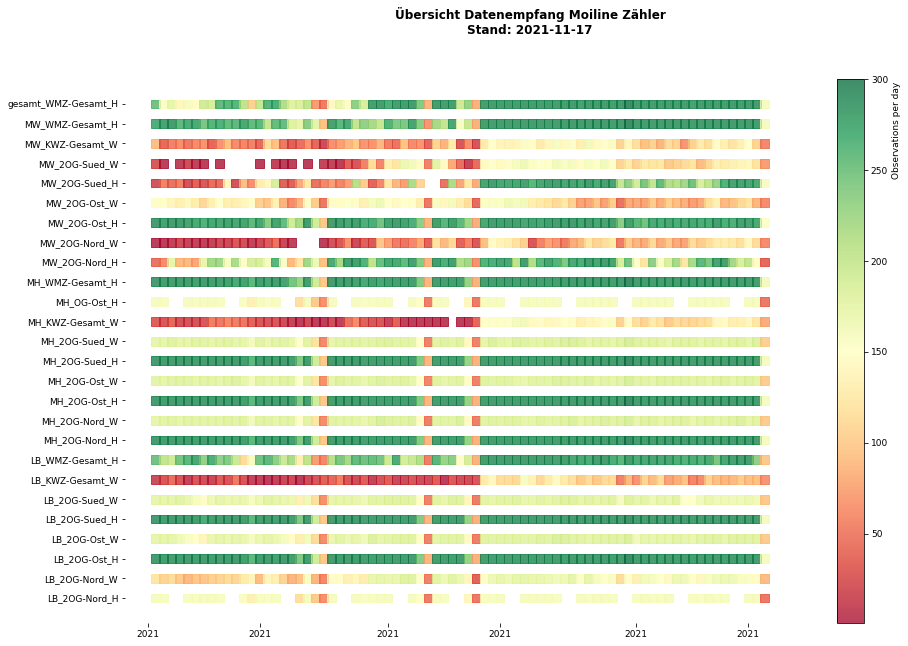

In [69]:
# plotting graph...
print(f'----creating overview graph...')
## preparing data
level_values = df.index.get_level_values
result = (df.groupby([level_values(i) for i in [0,1,2]]
                    +[pd.Grouper(freq='D', level=-1)]).size())  # count observations
result = pd.DataFrame(result, columns=['n_data'])   # make DataFrame of it
result.reset_index(level=[0,1,2],inplace=True)      # clean up DataFrame
result['meter'] = result['bui'] + '_' + result['app'] + '_' + result['type']    #clean up index
result.drop(['bui','app','type'],axis=1,inplace=True)   # remove unneeded columns
timemax = max([database[bui].index.max().date() for bui in eb.buid])
## plotting
f, ax = plt.subplots(figsize=(15,10))
ax.plot(result.index, result.meter, linestyle='None')
sc = ax.scatter(result.index, result.meter, c=result.n_data, s=len(result.index.unique()), alpha=0.75,marker = 's', cmap='RdYlGn')
cbar = f.colorbar(sc)
cbar.set_label("Observations per day ", loc='top')
f.suptitle(f'Übersicht Datenempfang Moiline Zähler\nStand: {timemax}')

#f.tight_layout()


In [62]:
f.show()

/var/folders/lt/yg_k1j750g57555v73hs91dc0000gn/T/ipykernel_5293/1831071131.py:1: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


In [51]:
result.index.max()

Timestamp('2021-11-17 00:00:00')

In [ ]:

## exporting graph.
exdir = os.path.join(eb.dir_results,'Allgemein')
if lehrstuhl:
    exdir = os.path.join(eb.dir_results_ls,'Allgemein')
if not os.path.isdir(exdir):
    os.makedirs(exdir)
f.savefig(os.path.join(exdir,f'EM_Monitoring_Datenempfang_Übersicht.png'),dpi=300)
print(f'finished!')